# **Imports**

In this notebook, I attempt to predict the next bank failure using historic financial ratios for all U.S. banks in the FDIC database. The target labels are binary, with a positive instance indicating that the bank will fail within a given time frame. I have specifically chosen the failure within 180 days to optimize for the fact that the FDIC releases the quarterly bank call report data with a lag of about 60 to 90 days after the end of the quarter. Also, this label seemed to give the best results. I also prioritized precision over recall, as shown in the confusion matrix below for the best model. The hyperparameters were selected via HyperOpt in another private notebook and are used below. Also, the results for different sets of hyperparameters are also recorded below. Financial ratios dataset is of shape (656438, 796) with 796 features and 656438 training examples for the past 90 quarters (see dataset page for more information). The best model achieved the following results on the test set: AUC=0.636, F1=0.413, Precision=0.83. 

In [1]:
# !pip install tensorflow-data-validation

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xg
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow as tf
# import tensorflow_data_validation as tfdv
from sklearn.model_selection import train_test_split


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/failed-banks-fdic-data/Failed_Bank_Dataset_2.csv
/kaggle/input/all-us-banks-financial-quarterly-ratios-2001-2023/total_bank_data.csv
/kaggle/input/all-us-banks-financial-quarterly-ratios-2001-2023/metric_definitions.csv


In [3]:
df = pd.read_csv('/kaggle/input/all-us-banks-financial-quarterly-ratios-2001-2023/total_bank_data.csv')


In [4]:
failed_df = pd.read_csv('/kaggle/input/failed-banks-fdic-data/Failed_Bank_Dataset_2.csv')


# **Data Visualization and Cleaning**

In [5]:
df.shape

(656438, 796)

In [6]:
# data_stats = tfdv.generate_statistics_from_dataframe(df)
# tfdv.visualize_statistics(data_stats)

In [7]:
#It appears that the data has lots of zeros so to simplify the data set we will remove all columns with 90 or more zeros 
# zero_percentage = (df == 0).mean()
# selected_columns = zero_percentage[zero_percentage < 0.9.index
# df_clean = df[selected_columns]


In [8]:
#joining fail date from failed banks list df to our df on cert column: 
merged_df = pd.merge(df, failed_df[['Closing_Date','Cert']], left_on='CERT', right_on='Cert', how='left')


In [9]:
del df 
del failed_df

In [10]:
merged_df.sort_values(by='REPDTE', inplace=True)
merged_df = merged_df.reset_index(drop=True)
#converting dates to correct format
merged_df['REPDTE'] = pd.to_datetime(merged_df['REPDTE'], format='%Y%m%d')
merged_df['Closing_Date'] = pd.to_datetime(merged_df['Closing_Date'])
#making label column


# **Making Labels and Splitting**

In [11]:
# Create a new column with binary values 
merged_df['FailWithin90Days'] = ((merged_df['Closing_Date'] - merged_df['REPDTE']).dt.days >= 0) & ((merged_df['Closing_Date'] - merged_df['REPDTE']).dt.days <= 90)
merged_df['FailWithin180Days'] = ((merged_df['Closing_Date'] - merged_df['REPDTE']).dt.days >= 0) & ((merged_df['Closing_Date'] - merged_df['REPDTE']).dt.days <= 180)                                              
merged_df['FailWithin365Days'] = ((merged_df['Closing_Date'] - merged_df['REPDTE']).dt.days >= 0) & ((merged_df['Closing_Date'] - merged_df['REPDTE']).dt.days <= 365)                                              
merged_df['FailWithin730Days'] = ((merged_df['Closing_Date'] - merged_df['REPDTE']).dt.days >= 0) & ((merged_df['Closing_Date'] - merged_df['REPDTE']).dt.days <= 730)                                              
            

In [12]:
#since the rows are ordered by date we can split the df into train,validation,test sets 
print(merged_df['REPDTE'].head())
print(merged_df['REPDTE'].tail())
#finding data set split dates for a rough 70:15:15 split

lower_date = pd.to_datetime(merged_df['REPDTE'][int(merged_df.shape[0]*0.70)])
top_date = pd.to_datetime(merged_df['REPDTE'][int(merged_df.shape[0]*0.85)])
last_date = pd.to_datetime(merged_df['REPDTE'].iloc[-1])
print(top_date)
print(lower_date)
print(last_date)

0   2001-03-31
1   2001-03-31
2   2001-03-31
3   2001-03-31
4   2001-03-31
Name: REPDTE, dtype: datetime64[ns]
656433   2023-06-30
656434   2023-06-30
656435   2023-06-30
656436   2023-06-30
656437   2023-06-30
Name: REPDTE, dtype: datetime64[ns]
2018-09-30 00:00:00
2014-09-30 00:00:00
2023-06-30 00:00:00


In [13]:
#dropping null column and unneeded columns 
merged_df.drop(['CBLRINDQ','Closing_Date','REPYEAR','STNAME','Cert'], axis=1, inplace=True)

In [14]:
# Split the DataFrame based on date criteria
train_data = merged_df[merged_df['REPDTE'] < lower_date]
validation_data = merged_df[(merged_df['REPDTE'] >= lower_date) & (merged_df['REPDTE'] < top_date)]
test_data = merged_df[(merged_df['REPDTE'] >= top_date) & (merged_df['REPDTE'] < last_date)]
last_data = merged_df[merged_df['REPDTE'] == last_date] 

#droping date column
train_data.drop(['REPDTE','NAME','CERT'], axis=1, inplace=True)
validation_data.drop(['REPDTE','NAME','CERT'], axis=1, inplace=True)
test_data.drop(['REPDTE','NAME','CERT'], axis=1, inplace=True)



last_data = last_data.reset_index(drop=True)

last_data_ids = last_data[['NAME','CERT']].copy()
last_data.drop(['REPDTE','NAME','CERT'], axis=1, inplace=True)



/tmp/ipykernel_26/526328061.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['REPDTE','NAME','CERT'], axis=1, inplace=True)
/tmp/ipykernel_26/526328061.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_data.drop(['REPDTE','NAME','CERT'], axis=1, inplace=True)
/tmp/ipykernel_26/526328061.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(['REPDTE','NAME','CERT'], axis=1, inplace=True)


In [15]:
del merged_df

In [16]:
Y1t = train_data['FailWithin90Days']
Y2t = train_data['FailWithin180Days']
Y3t = train_data['FailWithin365Days']
Y4t = train_data['FailWithin730Days']
Y1v = validation_data['FailWithin90Days']
Y2v = validation_data['FailWithin180Days']
Y3v = validation_data['FailWithin365Days']
Y4v = validation_data['FailWithin730Days']
Y1s = test_data['FailWithin90Days']
Y2s = test_data['FailWithin180Days']
Y3s = test_data['FailWithin365Days']
Y4s = test_data['FailWithin730Days']
Y1ld = last_data['FailWithin90Days']
Y2ld = last_data['FailWithin180Days']
Y3ld = last_data['FailWithin365Days']
Y4ld = last_data['FailWithin730Days']

In [17]:

Y_train = np.column_stack((Y1t, Y2t, Y3t,Y4t))
train_data.drop(['FailWithin90Days','FailWithin180Days','FailWithin365Days','FailWithin730Days'], axis=1, inplace=True)
Y_val = np.column_stack((Y1v, Y2v, Y3v,Y4v))
validation_data.drop(['FailWithin90Days','FailWithin180Days','FailWithin365Days','FailWithin730Days'], axis=1, inplace=True)
Y_test = np.column_stack((Y1s, Y2s, Y3s,Y4s))
test_data.drop(['FailWithin90Days','FailWithin180Days','FailWithin365Days','FailWithin730Days'], axis=1, inplace=True)
nalastdata = np.column_stack((Y1ld, Y2ld, Y3ld,Y4ld))
last_data.drop(['FailWithin90Days','FailWithin180Days','FailWithin365Days','FailWithin730Days'], axis=1, inplace=True)

In [18]:
# Calculate the class weight ratio
class_weight_ratio0 = (len(Y_train[:,0]) - sum(Y_train[:,0])) / sum(Y_train[:,0])
class_weight_ratio1 = (len(Y_train[:,1]) - sum(Y_train[:,1])) / sum(Y_train[:,1])
class_weight_ratio2 = (len(Y_train[:,2]) - sum(Y_train[:,2])) / sum(Y_train[:,2])
class_weight_ratio3 = (len(Y_train[:,3]) - sum(Y_train[:,3])) / sum(Y_train[:,3])
print(class_weight_ratio0)
print(class_weight_ratio1)
print(class_weight_ratio2)
print(class_weight_ratio3)
class_weight_ratios = [class_weight_ratio0,class_weight_ratio1,class_weight_ratio2,class_weight_ratio3]

879.8381502890173
436.0506692160612
215.046786389414
107.1255912961211


# **Data Validation & Transformation**

In [19]:
# train_stats = tfdv.generate_statistics_from_dataframe(train_data)
# schema = tfdv.infer_schema(statistics = train_stats)
# eval_stats = tfdv.generate_statistics_from_dataframe(validation_data)
# test_stats = tfdv.generate_statistics_from_dataframe(test_data)

# eval_anomalies =  tfdv.validate_statistics(statistics=eval_stats, schema=schema)
# test_anomalies = tfdv.validate_statistics(statistics=test_stats, schema=schema)

In [20]:

# tfdv.display_anomalies(eval_anomalies)
# print('#####################')
# tfdv.display_anomalies(test_anomalies)

# **Training**

In [21]:
# scale_pos_weight=class_weight_ratios[1]

params = {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.8, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None,'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 240, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None, 'eta': 0.30000000000000004, 'seed': 36}

xgb = xg.XGBClassifier(**params)

eval_set = [(train_data, Y_train[:,1]), (validation_data, Y_val[:,1])]
xgb.fit(train_data, Y_train[:,1],
# Fitting the model
          eval_set = eval_set,
          verbose=100)

[21:48:53] WARNING: ../src/learner.cc:767: 
Parameters: { "device" } are not used.

[0]	validation_0-logloss:0.43840	validation_1-logloss:0.43794
[100]	validation_0-logloss:0.00024	validation_1-logloss:0.00122
[200]	validation_0-logloss:0.00023	validation_1-logloss:0.00124
[239]	validation_0-logloss:0.00023	validation_1-logloss:0.00124


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eta=0.30000000000000004,
              eval_metric=None, feature_types=None, gamma=0.8, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=240, n_jobs=None, ...)

In [22]:

y_pred = xgb.predict_proba(validation_data)

# class_0_est_instances = y_pred[:, 0].sum()
# class_1_est_instances = y_pred[:, 1].sum()
# new_y_pred = y_pred * np.array([[1 / (class_0_est_instances),1 / (class_1_est_instances)]])
# new_y_pred_f = new_y_pred / np.sum(new_y_pred, axis=1, keepdims=1)

y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred[:,1]]


###################################################
# threshold = 0.5
# y_pred_binary = np.where(y_pred > threshold, 1, 0)

# f1_scores = f1_score(Y_val, y_pred_binary, average=None)
# auc = roc_auc_score(y_val, y_pred_binary,average=None)  
#####################################################

f1_scores = f1_score(Y_val[:,1], y_pred_binary)
auc = roc_auc_score(Y_val[:,1], y_pred_binary)  
print(f'AUC: {auc}')

# f1_scores will be an array of F1 scores for each label
print(f'F1 Score: {f1_scores}')

AUC: 0.73909460899828
F1 Score: 0.5866666666666667


In [23]:

y_pred = xgb.predict_proba(test_data)
# class_0_est_instances = y_pred[:, 0].sum()
# class_1_est_instances = y_pred[:, 1].sum()
# new_y_pred = y_pred * np.array([[1 / (class_0_est_instances),1 / (class_1_est_instances)]])
# new_y_pred_f = new_y_pred / np.sum(new_y_pred, axis=1, keepdims=1)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred[:,1]]


###################################################
# threshold = 0.5
# y_pred_binary = np.where(y_pred > threshold, 1, 0)

# f1_scores = f1_score(Y_val, y_pred_binary, average=None)
# auc = roc_auc_score(y_val, y_pred_binary,average=None)  
#####################################################

f1_scores = f1_score(Y_test[:,1], y_pred_binary)
auc = roc_auc_score(Y_test[:,1], y_pred_binary)  
print(f'AUC: {auc}')

# f1_scores will be an array of F1 scores for each label
print(f'F1 Score: {f1_scores}')

AUC: 0.6136311986672501
F1 Score: 0.35714285714285715


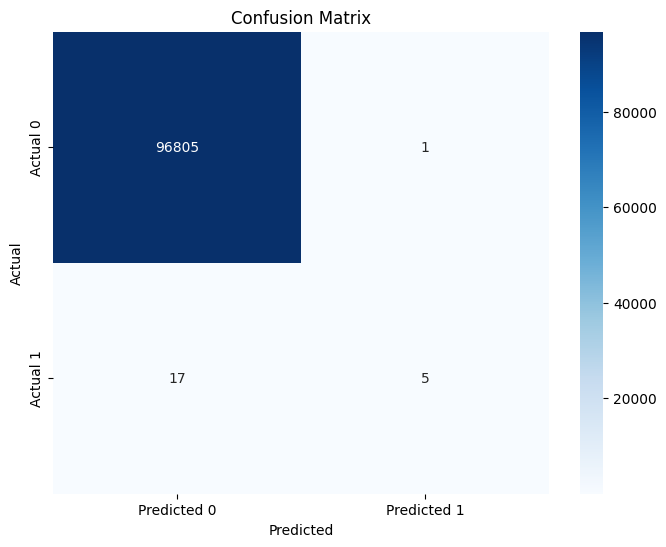

Confusion Matrix:
[[96805     1]
 [   17     5]]


In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Replace these with your actual predictions and true labels



# Create a confusion matrix
cm = confusion_matrix(Y_test[:,1], y_pred_binary)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Confusion Matrix:")
print(cm)


In [25]:
#predicting the next failer since last date: 
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

y_pred= xgb.predict(last_data)
last_data_ids['Pred'] = y_pred
sorted_results = last_data_ids.sort_values(by="Pred",ascending=False)
print(sorted_results[:20])

                              NAME   CERT  Pred
0                 FIRST STATE BANK  19163     0
3130               TRI-COUNTY BANK    977     0
3146              FIRST STATE BANK   9879     0
3145           AMERICAN STATE BANK   9967     0
3144               BANK OF DELIGHT     99     0
3143       G W JONES EXCHANGE BANK    999     0
3142             CAPON VALLEY BANK   9998     0
3141       JEFFERSON SECURITY BANK   9997     0
3140  FARMERS&MERCHANTS BK CRAIG C   9986     0
3139    FIRST STATE BANK OF UVALDE   9978     0
3138                      F&M BANK   9963     0
3137        SECURITY BANK&TRUST CO   9881     0
3136          VALLEY EXCHANGE BANK   9947     0
3135              RIVERS EDGE BANK   9935     0
3134      COMMERCIAL STB OF WAGNER   9932     0
3133        ANDERSON BROTHERS BANK   9923     0
3132                 MID PENN BANK   9889     0
3147                       BANK360   9875     0
3148                 ST HENRY BANK   9871     0
3149               BLOOMSDALE BANK   978

In [26]:
# LL -LogLoss (train/val)
# US-unscaled
# FD-full data
# NFE-no feature engineering 
# UT-untuned
# 180-Failed within 180 days (target)
# Log- objective binary:logistic
# SPW- scale_pos_weight
# 300- number of estimators 

# Data Split is 70 tain 15 Val 15 Test 

# US_FD_NFE_UT_180_Log_SPW_300 = LL 0.00117-0.00207,Val AUC-0.815 F1-O.522 Precision-0.44, Test AUC-0.636 F1-0.3485 Precision-0.46
# ValCM:[[97659    36]
#         [   17    29]] 
# ##############################################################################################
# US_FD_NFE_UT_180_Log_300 = LL 0.00022-0.00152,Val AUC-0.695 F1-O.493 Precision-0.66, Test AUC-0.613 F1-0.357 Precision-0.83
# ValCM: [[97686     9]
#         [   28    18]]
# TestCM:
#     [[101519      1]
#  [    17      5]]
# ############################################################################################   
# US_FD_NFE_UT_180_Log_200 = LL 0.00136-0.00124,Val AUC-0.717 F1-O.526 Precision-0.66, Test AUC-0.636 F1-0.413 Precision-0.85   
# ValCM: [[97685    10]
#         [   26    20]]
# TestCM [[101519      1]
#          [    16      6]]
# ########################################################################################
         
# #Tuning with HPO US_FD_NFE_UT_180_Log
# params = {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 60, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'eta': 0.1, 'seed': 74}        
#                             LL 0.00097-0.00136,Val AUC-0.728 F1-O.583 Precision-0.80, Test AUC-0.613 F1-0.357 Precision-0.83
# ValCM: [[97690     5]
#          [   25    21]]
# TestCM: [[101519      1]
#          [    17      5]]
# #############################################################################################
# parmas = {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.8, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 240, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'eta': 0.30000000000000004, 'seed': 36}
#                            LL 0.00024-0.00128,Val AUC-0.782 F1-O.658 Precision-0.80, Test AUC-0.636 F1-0.413 Precision-0.83  
# ValCM: [[97688     7]
#          [   20    26]]
# TestCM: [[101519      1]
#          [    16      6]]
# #########################################################################################
# #With Feature engineering  + Tuneing (Lag1)
# params = {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 1.0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 160, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.5, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None, 'eta': 0.2, 'seed': 36}
#                              LL 0.00145-0.00125,Val AUC-0.771 F1-O.649 Precision-0.80, Test AUC-0.636 F1-0.399 Precision-0.83  
# ValCm = [[97689     6]
#          [   21    25]]
# TestCM = [[101518      2]
#          [    16      6]]
    
         

         
         
         
         
         
         
         
         
         
         
         
         
         